In [19]:
# ! pip install skforecast

In [20]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import xgboost as xgb

from scipy import stats

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster

from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import  KNeighborsRegressor
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg

from skforecast.utils import load_forecaster

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras import optimizers,callbacks
from keras.models import Sequential, Model
from keras.layers import Conv1D, Conv2D,MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout, MultiHeadAttention, GlobalAveragePooling1D, Input
from keras import optimizers

# Calculo de metricas
# ==============================================================================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn import metrics

# Configuración warnings
# ==============================================================================
import warnings
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")
# warnings.filterwarnings('ignore')

In [21]:
def evaluacion_metrica(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'R2: {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    print(f'MSE: {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE: {metrics.mean_absolute_error(y_true, y_pred)}')



In [22]:
# Carga de datos
# ==============================================================================
folder = ""
parametro = 'temperatura'
output=parametro
inputs = [
          'fecha', 'temperatura',
          'ambiente'
          ]
usecols = inputs.copy()

datos = pd.read_csv(folder + "laguna_datos_horarios_rellenos" + ".csv",sep=',', usecols=usecols)

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%d/%m/%Y %H:%M')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('H')
datos = datos.sort_index()

datos.info()

datos.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2113 entries, 2023-06-17 00:00:00 to 2023-09-13 00:00:00
Freq: H
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperatura  2113 non-null   float64
 1   ambiente     2113 non-null   float64
dtypes: float64(2)
memory usage: 49.5 KB


,temperatura,ambiente
fecha,,
2023-06-17 00:00:00,31.500,22.000000
2023-06-17 01:00:00,31.470,21.780000
2023-06-17 02:00:00,31.235,21.201000
2023-06-17 03:00:00,31.295,22.439250
2023-06-17 04:00:00,31.375,23.058375


In [23]:
#datos["ta-1"] = datos["ambiente"].shift(1)
#datos["ta-2"] = datos["ambiente"].shift(2)
#datos["ta-3"] = datos["ambiente"].shift(3)
#datos["ta-4"] = datos["ambiente"].shift(4)
#datos["ta-5"] = datos["ambiente"].shift(5)
datos["ta-24"] = datos["ambiente"].shift(24)
datos["ta-36"] = datos["ambiente"].shift(36)
datos["ta-48"] = datos["ambiente"].shift(48)
datos["ta-96"] = datos["ambiente"].shift(96)
datos["ta-120"] = datos["ambiente"].shift(120)

#datos = datos.drop(columns=["ambiente"])
datos = datos.dropna()

datos.tail(10)

,temperatura,ambiente,ta-24,ta-36,ta-48,ta-96,ta-120
fecha,,,,,,,
2023-09-12 15:00:00,30.3750,27.69,27.68,23.64,27.38,27.64,27.88
2023-09-12 16:00:00,30.5875,27.56,27.29,23.53,27.49,27.37,27.75
2023-09-12 17:00:00,30.7450,27.40,27.23,23.08,27.13,27.01,27.10
2023-09-12 18:00:00,30.7500,26.82,26.89,22.19,26.80,26.62,26.93
2023-09-12 19:00:00,31.1600,25.94,26.33,22.06,26.22,26.06,26.44
2023-09-12 20:00:00,31.5375,25.82,25.75,22.13,26.00,25.37,25.81
2023-09-12 21:00:00,31.4325,25.31,25.56,24.07,25.87,25.11,25.53
2023-09-12 22:00:00,31.3350,23.93,25.07,25.95,25.88,25.01,25.30
2023-09-12 23:00:00,31.1775,23.70,24.84,27.05,25.78,24.93,25.06


## MODELADO

In [24]:
def rmsle_cv(model,x,y):
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(x.values)
    rmse= cross_val_score(model, x.values, y, scoring=None, cv = kf)
    return(rmse)

## (Linear Regression)

In [25]:
# y_train = datos["temperatura"].loc[:].values
# datos_train = datos.drop(columns=['temperatura'])

# lm = LinearRegression()
# model = lm.fit(datos_train,y_train)

# res_lineal = rmsle_cv(lm,datos_train,y_train)
# print(res_lineal)

# l = plt.plot(lm.predict(datos_train), 'o', color='blue', label="Estimado", marker='x')
# plt.setp(l, markersize=3)

# plt.title('Estimado')
# q = plt.plot(y_train, 'o', color='red', label="Original")
# plt.setp(q, markersize=3)
# category_names = ['Estimado', 'Original']
# legend = plt.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
#               loc='lower left', fontsize='medium')
# plt.show()

## LR, Lasso, KNN, MLP, DT, RF

In [26]:
def ML_algorithms(algo):
    if algo == 'KNN':
      model = KNeighborsRegressor(3, weights='distance') # RDregresor
      return model

    if algo=="MLP":
      #(64, 32)	0.01	200.0
      model = MLPRegressor(hidden_layer_sizes=(32,32), learning_rate_init=0.01, max_iter=400, random_state=1)
      return model

    if algo=='DT':
      model = DecisionTreeRegressor(max_depth=16, min_samples_split=2,random_state=0)
      return model

    if algo=="RFR":
      #antes 16 y 4
      model =  RandomForestRegressor(random_state=0, n_estimators=8, min_samples_split=16)
      return model

    if algo=="LR":
        #antes 16 y 4
        model =  LinearRegression()
        return model

    if algo=="Lasso":
      #antes 16 y 4
      model =  Lasso()
      return model

    if algo=="SVM":
      #antes 16 y 4
      model =  SVR()
      return model

In [29]:
algoritmos = ['LR','Lasso','KNN', 'MLP', 'DT', 'RFR', 'SVM']
cv_scores = pd.DataFrame()
dfe=datos.copy()

inputs_temp = [
          'ambiente','ta-24','ta-36','ta-48','ta-96','ta-120'
          ]

for algo in algoritmos:

    print("Algoritmo", algo)
    dfwork = dfe.copy()

    x = dfwork[inputs_temp].values
    y = dfwork[output].values

    lm = ML_algorithms(algo)

    kf = KFold(5, shuffle=True, random_state=42)
    icv=0
    acc_score = []
    for train, test in kf.split(x):
      X_train, X_test, y_train, y_test = x[train], x[test], y[train], y[test]
      model = lm.fit(X_train,y_train)
      ypred = model.predict(X_test)

      r2 = r2_score(y_test, ypred)
      mae = mean_absolute_error(y_test, ypred)
      mse = mean_squared_error(y_test, ypred)
      icv = icv + 1

      result = {"Algorithm": algo, "cv": icv, "r2": r2, "MSE": mse, 'MAE': mae}

      # Assuming cv_scores is an existing DataFrame
      new_entry = pd.DataFrame([result])
      cv_scores = pd.concat([cv_scores, new_entry], ignore_index=True)
      print(result)

print(cv_scores)

r = cv_scores.groupby(['Algorithm']).mean()
print(r)

Algoritmo LR
{'Algorithm': 'LR', 'cv': 1, 'r2': 0.39310733904645523, 'MSE': 3.703751443803101, 'MAE': 1.4838160694481386}
{'Algorithm': 'LR', 'cv': 2, 'r2': 0.41574658763908856, 'MSE': 3.9375401699944406, 'MAE': 1.560738884105487}
{'Algorithm': 'LR', 'cv': 3, 'r2': 0.4930927068341877, 'MSE': 3.0681197205790203, 'MAE': 1.3903832458780045}
{'Algorithm': 'LR', 'cv': 4, 'r2': 0.4361285383021044, 'MSE': 3.881388652525386, 'MAE': 1.5625494361796441}
{'Algorithm': 'LR', 'cv': 5, 'r2': 0.4582349041792553, 'MSE': 3.596162612835119, 'MAE': 1.4770860815401567}
Algoritmo Lasso
{'Algorithm': 'Lasso', 'cv': 1, 'r2': 0.36165105909659434, 'MSE': 3.8957231873696134, 'MAE': 1.5667021727921175}
{'Algorithm': 'Lasso', 'cv': 2, 'r2': 0.34982174703560986, 'MSE': 4.381836604700287, 'MAE': 1.7057879280367412}
{'Algorithm': 'Lasso', 'cv': 3, 'r2': 0.3957583821995704, 'MSE': 3.657247880554074, 'MAE': 1.5461438141686696}
{'Algorithm': 'Lasso', 'cv': 4, 'r2': 0.34440496450693914, 'MSE': 4.51276452926442, 'MAE': 1

## KNN, RF, SVM, DT, LR

In [30]:
entreno = 120

datos_entreno = datos.iloc[:-entreno] # PARA TENER UNA COPIA DEL ORIGINAL Y MODIFICAR LA COPIA

X_train = datos[inputs_temp].iloc[:-entreno]
y_train = datos[output].iloc[:-entreno]
X_test = datos[inputs_temp].iloc[-entreno:]
y_test = datos[output].iloc[-entreno:]

In [31]:
# model_LR =  linear_model.LinearRegression().fit(X_train,y_train)
# model_KN = KNeighborsRegressor(2,weights='distance').fit(X_train,y_train)
# #model_LR = Lasso(alpha=1.0).fit(X_train,y_train) #LASSO y RIDGE muy malos
# #model_LR = Ridge(alpha=1.0).fit(X_train,y_train) #LASSO y RIDGE muy malos
# #model_LR = SVR(kernel='linear', C=1.0, epsilon=0.1).fit(X_train,y_train)
# model_RF = RandomForestRegressor(random_state=0, n_estimators=8, min_samples_split=16).fit(X_train,y_train)

# ypred = model_LR.predict(X_test)

# predicciones = pd.DataFrame() #ESTO PARA CREAR UN DATAFRAME SOLO CON LAS PREDICCIONES, PARA PINTAR LUEGO
# predicciones_fecha = pd.DataFrame() #ESTO PARA CREAR UN DATAFRAME SOLO CON LAS PREDICCIONES, PARA PINTAR LUEGO

# predicciones["pred"] = ypred

# r2 = r2_score(y_test, ypred)
# mae = mean_absolute_error(y_test, ypred)
# mse = mean_squared_error(y_test, ypred)

# predicciones_fecha = X_test.copy()
# predicciones_fecha["temperatura"] = predicciones["pred"].values

# print(predicciones_fecha)

In [32]:
def KNN(nestimators):
      model = KNeighborsRegressor(nestimators,weights='distance') # RDregresor
      return model

def DT(depth, mss):
  model = DecisionTreeRegressor(max_depth=depth, min_samples_split=mss,random_state=0)
  return model

def RFR(nestimators, mss):
  model =  RandomForestRegressor(random_state=0, n_estimators=nestimators, min_samples_split=mss)
  return model

def SVR_V(kernel, epsilon):
  model = SVR(kernel = kernel, C = 1.0, epsilon= epsilon)
  return model

In [33]:
dfe=datos.copy()

max_depth = [4,8,10,16,30,60,120] #DT
mss = [2,4,8,16,32,64] #DT , RFR
nstimator=[1,2,3,4,5,6,7,8,9,10] # RFR, KNN
kernels = ['linear','poly','rbf','simoid','precomputed'] # SVR
epsilons = [0.1,0.2,0.5,1.0] # SVR


best_model = None
best_score = 0
cv_scores_DT = pd.DataFrame()
cv_scores_KNN = pd.DataFrame()
cv_scores_RF = pd.DataFrame()
cv_scores_SVR = pd.DataFrame()
cv_scores_best = pd.DataFrame()

#================================ RF ==================================

for ns in nstimator:
    for ms in mss:

        dfwork = dfe.copy()

        x = dfwork[inputs_temp].values
        y = dfwork[output].values

        model = RFR(ns, ms)
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        scores = cross_val_score(model, x, y, cv=cv, n_jobs=-1)

        if (scores.mean() > best_score):
            best_score = scores.mean()
            best_model = model
            result = {"Parametro1": ns, "Parametro2": ms, 'score': scores.mean()}

            # Assuming cv_scores_DT is an existing DataFrame
            new_entry = pd.DataFrame([result])  # Create a new DataFrame with a single row
            cv_scores_RF = pd.concat([cv_scores_RF, new_entry], ignore_index=True)
print("=============== RF =================")
print(best_model)
print(best_score)
print(cv_scores_RF.sort_values('score', ascending=False))

#================================ DT ==================================

best_model = None
best_score = 0

for ns in max_depth:

    for ms in mss:

        dfwork = dfe.copy()

        x = dfwork[inputs_temp].values
        y = dfwork[output].values

        model = DT(ns, ms)
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        scores = cross_val_score(model, x, y, cv=cv, n_jobs=-1)

        if (scores.mean() > best_score):
            best_score = scores.mean()
            best_model = model
            result = {"Parametro1": ns, "Parametro2": ms, 'score': scores.mean()}

            # Assuming cv_scores_DT is an existing DataFrame
            new_entry = pd.DataFrame([result])  # Create a new DataFrame with a single row
            cv_scores_DT = pd.concat([cv_scores_DT, new_entry], ignore_index=True)
print("=============== DT =================")
print(best_model)
print(best_score)
print(cv_scores_DT.sort_values('score', ascending=False))


#================================ KNN ==================================

best_model = None
best_score = 0

for nstim in nstimator:
    for ms in mss:

      dfwork = dfe.copy()

      x = dfwork[inputs_temp].values
      y = dfwork[output].values

      model = KNN(nstim)
      cv = KFold(n_splits=5, random_state=1, shuffle=True)
      scores = cross_val_score(model, x, y, cv=cv, n_jobs=-1)

      if (scores.mean() > best_score):
          best_score = scores.mean()
          best_model = model
          result = {"Parametro1": ns, "Parametro2": ms, 'score': scores.mean()}
          new_entry = pd.DataFrame([result])  # Create a new DataFrame with a single row
          cv_scores_KNN = pd.concat([cv_scores_KNN, new_entry], ignore_index=True)

print("=============== KNN =================")
print(best_model)
print(best_score)
print(cv_scores_KNN.sort_values('score', ascending=False))

#================================ SVR ==================================

# best_model = None
# best_score = 0

# for kernel in kernels:
#     for epsilon in epsilons:

#       dfwork = dfe.copy()

#       x = dfwork[inputs_temp].values
#       y = dfwork[output].values

#       model = SVR_V(kernel, epsilon)
#       cv = KFold(n_splits=5, random_state=1, shuffle=True)
#       scores = cross_val_score(model, x, y, cv=cv, n_jobs=-1)

#       if (scores.mean() > best_score):
#           best_score = scores.mean()
#           best_model = model
#           result = {"Parametro1": ns, "Parametro2": ms, 'score': scores.mean()}
#           new_entry = pd.DataFrame([result])  # Create a new DataFrame with a single row
#           cv_scores_SVR = pd.concat([cv_scores_SVR, new_entry], ignore_index=True)

# print("=============== SVR =================")
# print(best_model)
# print(best_score)
# print(cv_scores_SVR.sort_values('score', ascending=False))

=============== RF =================
RandomForestRegressor(n_estimators=10, random_state=0)
0.6790342128072894
    Parametro1  Parametro2     score
19          10           2  0.679034
18           9           2  0.675406
17           8           2  0.668321
16           7           2  0.664726
15           6           2  0.657155
14           5           4  0.647744
13           5           2  0.647365
12           4           2  0.629952
11           3           4  0.589864
10           3           2  0.587857
9            2          32  0.532488
8            2          16  0.531330
7            2           4  0.531284
6            2           2  0.517965
5            1          64  0.428597
4            1          32  0.418189
3            1          16  0.391616
2            1           8  0.335739
1            1           4  0.324534
0            1           2  0.323271
=============== DT =================
DecisionTreeRegressor(max_depth=10, min_samples_split=16, random_state=0)
0

### Modelos definitivos

In [35]:
inputs_temp = [
          'ambiente','ta-24','ta-36','ta-48','ta-96','ta-120'
          ]
outputs = ['temperatura']


X = datos[inputs_temp]
y = datos[output]


model_LR = LinearRegression().fit(X, y)
model_KNN = KNeighborsRegressor(n_neighbors=3, weights='distance').fit(X, y)
model_DT = DecisionTreeRegressor(max_depth=16, min_samples_split=32, random_state=0).fit(X, y)
model_RF =  RandomForestRegressor(n_estimators=10, random_state=0).fit(X, y)
# model_SVR = SVR(kernel = kernel, C = 1.0, epsilon= epsilon).fit(X, y)

# REDES NEURONALES

## CNN

In [36]:
def create_model(opt, loss="mse"):
  model = Sequential()
  # opt = tf.optimizers.Adam(learning_rate=0.1)
  # model.add(Dense(32, activation="relu"))
  model.add(Conv1D(128, 2, activation="sigmoid", input_shape=(6, 1)))
  model.add(Dense(64, activation="sigmoid"))
  model.add(Dense(32, activation="relu"))
  model.add(Flatten())
  model.add(Dense(1))
  model.compile(loss=loss, optimizer='adam')
  # model.summary()
  return model

#### Aquí con todos los datos

In [37]:
results = pd.DataFrame()

dfwork = dfe.copy()
x = dfwork[inputs_temp].to_numpy()
y = dfwork[output].to_numpy()
x = x.reshape(x.shape[0], x.shape[1], 1)
opt = "adam"

for i in range(0,5):
    xtrain, xtest, ytrain, ytest= train_test_split(x, y, train_size=0.8)
    print(len(xtrain), len(ytrain))
    model = create_model(opt)
    # if show_model:
    #  model.summary()
    #  show_model=False
    model.fit(xtrain, ytrain, batch_size=16, epochs=500, verbose=0)
    #print(xtest)
    ypred = model.predict(xtest)

    r2 = r2_score(ytest, ypred)
    mae = mean_absolute_error(ytest, ypred)
    mse = mean_squared_error(ytest, ypred)
    # plot_scatter(ytest, ypred)
    mr = { 'cv': i+1,
          'R2': r2,
          'MSE':mse,
          'MAE':mae}

    new_entry = pd.DataFrame([mr])  # Create a new DataFrame with a single row
    results = pd.concat([results, new_entry], ignore_index=True)

print(results)

r = results.mean()
print(r)

1594 1594
13/13 [==============================] - 0s 6ms/step
1594 1594
13/13 [==============================] - 0s 2ms/step
1594 1594
13/13 [==============================] - 0s 2ms/step
1594 1594
13/13 [==============================] - 0s 2ms/step
1594 1594
13/13 [==============================] - 0s 3ms/step
   cv        R2       MSE       MAE
0   1  0.491799  3.237876  1.362763
1   2  0.508473  3.380811  1.416922
2   3  0.509845  3.082742  1.365464
3   4  0.520903  2.889514  1.291410
4   5  0.464499  3.781131  1.481730
cv     3.000000
R2     0.499104
MSE    3.274415
MAE    1.383658
dtype: float64


#### Aquí con los datos de train y test

In [38]:
results = pd.DataFrame()

dfwork = dfe.copy()
x = dfwork[inputs_temp].to_numpy()
y = dfwork[output].to_numpy()
x = x.reshape(x.shape[0], x.shape[1], 1)
opt = "adam"


model_CNN = create_model(opt)
model_CNN.fit(x, y, batch_size=24, epochs=500, verbose=1)
#print(xtest)
# ypred = model_CNN.predict(X_test)

Epoch 1/500
84/84 [==============================] - 2s 5ms/step - loss: 390.6045
Epoch 2/500
84/84 [==============================] - 0s 4ms/step - loss: 6.8158
Epoch 3/500
84/84 [==============================] - 0s 4ms/step - loss: 6.5104
Epoch 4/500
84/84 [==============================] - 0s 3ms/step - loss: 6.5022
Epoch 5/500
84/84 [==============================] - 0s 4ms/step - loss: 6.5069
Epoch 6/500
84/84 [==============================] - 0s 4ms/step - loss: 6.5048
Epoch 7/500
84/84 [==============================] - 0s 4ms/step - loss: 6.5621
Epoch 8/500
84/84 [==============================] - 0s 4ms/step - loss: 6.5169
Epoch 9/500
84/84 [==============================] - 0s 3ms/step - loss: 6.5267
Epoch 10/500
84/84 [==============================] - 0s 4ms/step - loss: 6.5103
Epoch 11/500
84/84 [==============================] - 0s 4ms/step - loss: 6.4975
Epoch 12/500
84/84 [==============================] - 0s 3ms/step - loss: 6.5118
Epoch 13/500
84/84 [===============

## RNN

In [39]:
def create_model_RNN(opt, loss="mse"):
  model_RNN = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=(6, 1)),  # Capa RNN 1
    tf.keras.layers.SimpleRNN(64, return_sequences=True),  # Capa RNN 2
    tf.keras.layers.SimpleRNN(128, return_sequences=True),  # Capa RNN 3
    tf.keras.layers.SimpleRNN(64, return_sequences=True),  # Capa RNN 4
    tf.keras.layers.SimpleRNN(32),  # Capa RNN 5
    tf.keras.layers.Dense(1)  # Capa de salida con una neurona
])

  model_RNN.compile(loss=loss, optimizer=opt)
  return model_RNN

In [40]:
results = pd.DataFrame()

dfwork = dfe.copy()
x = dfwork[inputs_temp].to_numpy()
y = dfwork[output].to_numpy()
x = x.reshape(x.shape[0], x.shape[1], 1)
opt = "adam"

for i in range(0,5):

    xtrain, xtest, ytrain, ytest= train_test_split(x, y, train_size=0.8)
    print(len(xtrain), len(ytrain))
    model = create_model_RNN(opt)
    # if show_model:
    #  model.summary()
    #  show_model=False
    model.fit(xtrain, ytrain, epochs=100, verbose=0)
    #print(xtest)
    ypred = model.predict(xtest)

    r2 = r2_score(ytest, ypred)
    mae = mean_absolute_error(ytest, ypred)
    mse = mean_squared_error(ytest, ypred)
    # plot_scatter(ytest, ypred)
    mr = { 'cv': i,
          'MSE':mse,
          'R2': r2,
          'MAE':mae}

    new_entry = pd.DataFrame([mr])  # Create a new DataFrame with a single row
    results = pd.concat([results, new_entry], ignore_index=True)

print(results)

r = results.mean()
print(r)

1594 1594
13/13 [==============================] - 1s 6ms/step
1594 1594
13/13 [==============================] - 0s 4ms/step
1594 1594
13/13 [==============================] - 0s 4ms/step
1594 1594
13/13 [==============================] - 1s 6ms/step
1594 1594
13/13 [==============================] - 0s 4ms/step
   cv       MSE        R2       MAE
0   0  6.679917 -0.021546  2.195038
1   1  6.474667 -0.007984  2.158022
2   2  6.386332 -0.001196  2.117224
3   3  5.806354 -0.000734  2.015240
4   4  6.718921 -0.001189  2.182765
cv     2.000000
MSE    6.413238
R2    -0.006530
MAE    2.133658
dtype: float64


#### Aquí con los datos de train y test

In [41]:
dfwork = dfe.copy()
x = dfwork[inputs_temp].to_numpy()
y = dfwork[output].to_numpy()
x = x.reshape(x.shape[0], x.shape[1], 1)

# Crear una RNN de 5 capas
model_RNN = create_model_RNN('adam')

# Entrenar la RNN
model_RNN.fit(x, y, epochs=100, verbose=1)

# Realizar predicciones
# predicted = model_RNN.predict(X_test)

# # Imprimir las predicciones
# print("Predicciones:")
# print(predicted)

Epoch 1/100
63/63 [==============================] - 7s 48ms/step - loss: 606.2545
Epoch 2/100
63/63 [==============================] - 2s 33ms/step - loss: 474.6989
Epoch 3/100
63/63 [==============================] - 2s 27ms/step - loss: 391.7755
Epoch 4/100
63/63 [==============================] - 2s 27ms/step - loss: 321.5522
Epoch 5/100
63/63 [==============================] - 2s 27ms/step - loss: 262.0089
Epoch 6/100
63/63 [==============================] - 2s 27ms/step - loss: 211.7878
Epoch 7/100
63/63 [==============================] - 2s 26ms/step - loss: 169.6737
Epoch 8/100
63/63 [==============================] - 3s 50ms/step - loss: 134.7892
Epoch 9/100
63/63 [==============================] - 2s 27ms/step - loss: 106.2075
Epoch 10/100
63/63 [==============================] - 2s 27ms/step - loss: 82.9930
Epoch 11/100
63/63 [==============================] - 2s 26ms/step - loss: 64.4405
Epoch 12/100
63/63 [==============================] - 2s 27ms/step - loss: 49.7620
Epoc

In [42]:
# Carga de datos
# ==============================================================================
folder = ""
parametro = 'temp'
output=parametro
inputs = [
          'fecha', 'ambiente'
          ]

usecols = inputs.copy()

datos_hist = pd.read_csv(folder + "datos_historico" + ".csv",sep=',', usecols=usecols)


# Preparación del dato
# ==============================================================================
datos_hist['fecha'] = pd.to_datetime(datos_hist['fecha'], format='%d/%m/%Y')
datos_hist = datos_hist.set_index('fecha')
datos_hist = datos_hist.rename(columns={'x': 'y'})
datos_hist = datos_hist.asfreq('D')
datos_hist = datos_hist.sort_index()

datos_hist.info()

#datos = datos.iloc[:-180]

datos_hist.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22249 entries, 1947-01-01 to 2007-11-30
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ambiente  22249 non-null  float64
dtypes: float64(1)
memory usage: 347.6 KB


,ambiente
fecha,
1947-01-01,13.0
1947-01-02,9.0
1947-01-03,10.5
1947-01-04,9.5
1947-01-05,8.5


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22249 entries, 1947-01-01 to 2007-11-30
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ambiente  22249 non-null  float64
dtypes: float64(1)
memory usage: 347.6 KB


<Axes: xlabel='fecha'>

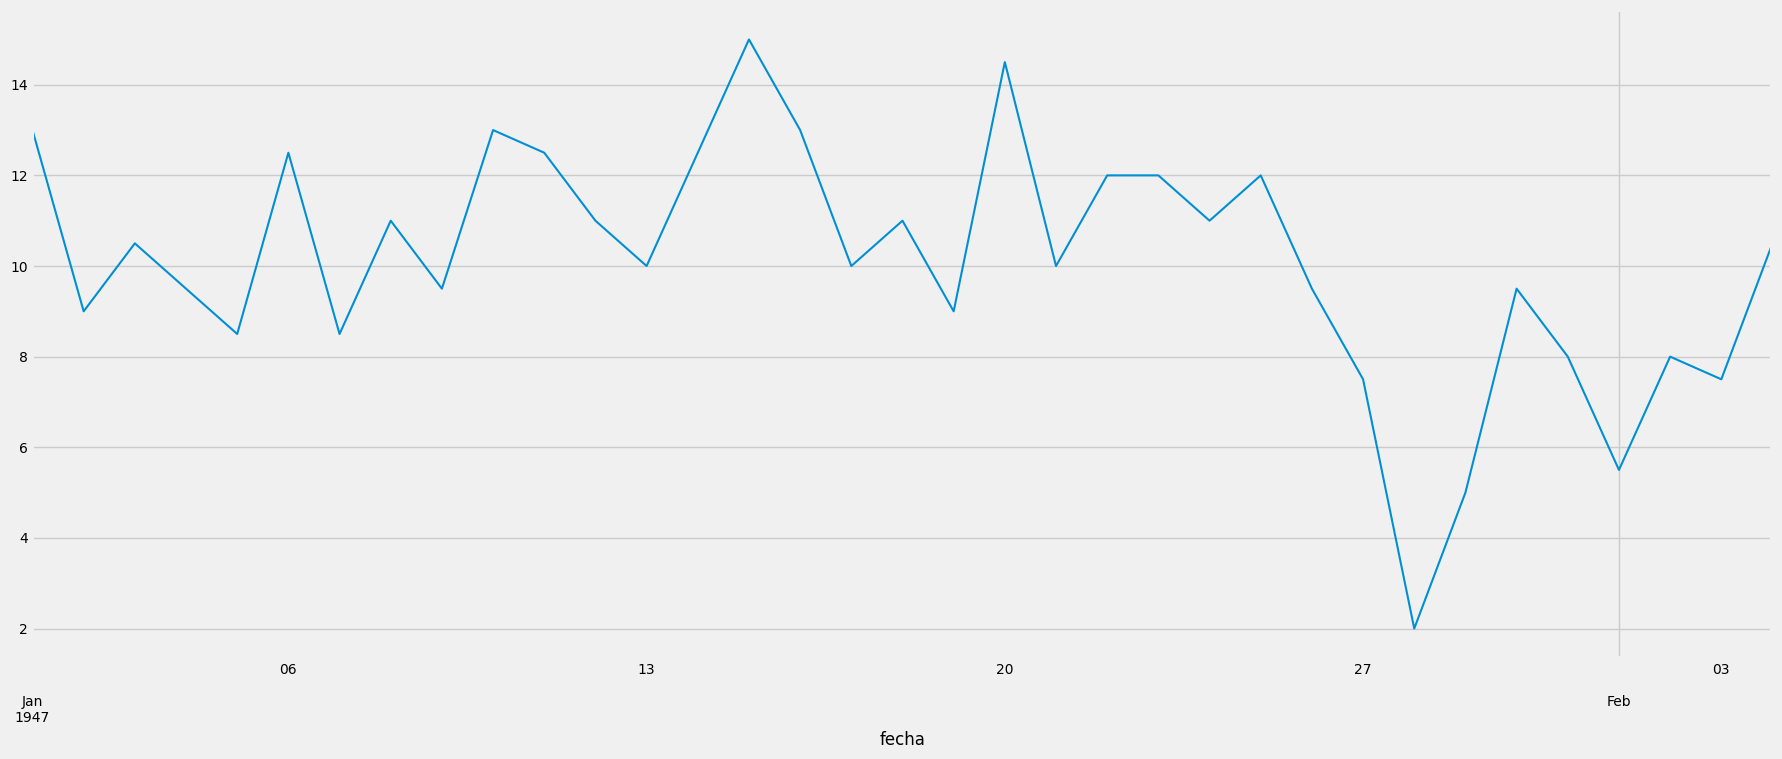

In [43]:
# dfwork = datos_hist[datos_hist['NOMBRE']=="LAGUNA DE LA MATA"] # CAMBIAR

dfwork = datos_hist.dropna()

dfwork.info()

fig, ax = plt.subplots(figsize=(20, 8))
dfwork['ambiente'].iloc[:35].plot(ax=ax, label='Temp_Laguna_mata')

In [44]:
dfwork["ta-24"] = dfwork["ambiente"].shift(1)
dfwork["ta-36"] = dfwork["ambiente"].shift(2)
dfwork["ta-48"] = dfwork["ambiente"].shift(3)
dfwork["ta-96"] = dfwork["ambiente"].shift(4)
dfwork["ta-120"] = dfwork["ambiente"].shift(5)

dfwork = dfwork.dropna()

#X_test.info()
dfwork.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22244 entries, 1947-01-06 to 2007-11-30
Freq: D
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ambiente  22244 non-null  float64
 1   ta-24     22244 non-null  float64
 2   ta-36     22244 non-null  float64
 3   ta-48     22244 non-null  float64
 4   ta-96     22244 non-null  float64
 5   ta-120    22244 non-null  float64
dtypes: float64(6)
memory usage: 1.2 MB


In [45]:
ypred_CNN = model_CNN.predict(dfwork)
ypred_RNN = model_RNN.predict(dfwork)
ypred_LR = model_LR.predict(dfwork)
ypred_DT = model_DT.predict(dfwork)
ypred_KN = model_KNN.predict(dfwork)
ypred_RF = model_RF.predict(dfwork)

696/696 [==============================] - 3s 4ms/step


In [46]:
dfwork["temp_agua_CNN"] = ypred_CNN
dfwork["temp_agua_RNN"] = ypred_RNN
dfwork["temp_agua_LR"] = ypred_LR
dfwork["temp_agua_DT"] = ypred_DT
dfwork["temp_agua_KN"] = ypred_KN
dfwork["temp_agua_RF"] = ypred_RF

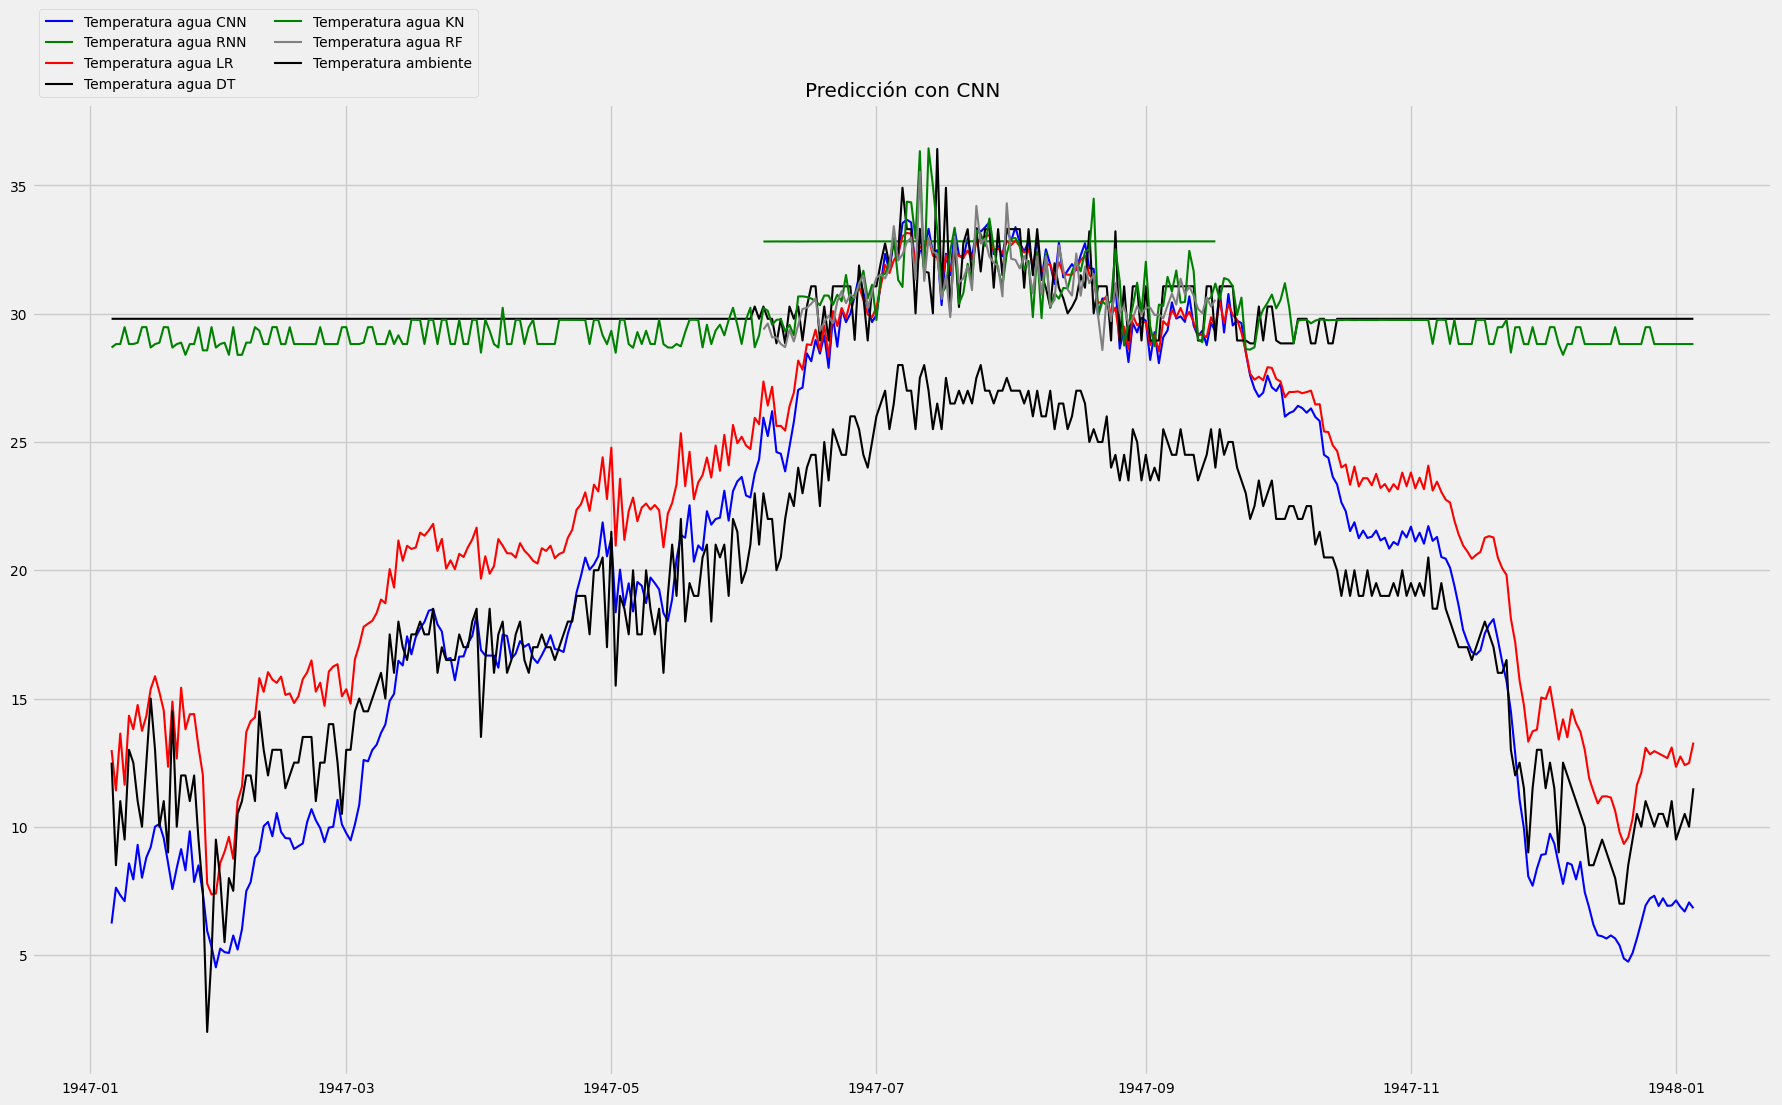

In [47]:
plt.figure(figsize=(20,12))

plt.title('Y_predict')
l1 = plt.plot(dfwork["temp_agua_CNN"].iloc[:365], color='blue', label="Temperatura agua CNN")
plt.setp(l1, markersize=8)

l2 = plt.plot(dfwork["temp_agua_RNN"].iloc[150:255], color='green', label="Temperatura agua RNN")
plt.setp(l2, markersize=8)

l3 = plt.plot(dfwork["temp_agua_LR"].iloc[:365], color='red', label="Temperatura agua LR")
plt.setp(l3, markersize=8)

l3 = plt.plot(dfwork["temp_agua_DT"].iloc[:365], color='black', label="Temperatura agua DT")
plt.setp(l3, markersize=8)

l4 = plt.plot(dfwork["temp_agua_KN"].iloc[:365], color='green', label="Temperatura agua KN")
plt.setp(l4, markersize=8)

l5 = plt.plot(dfwork["temp_agua_RF"].iloc[150:255], color='grey', label="Temperatura agua RF")
plt.setp(l5, markersize=8)

plt.title('Predicción con CNN')
q = plt.plot(dfwork["ambiente"].iloc[:365] , color='black', label="Temperatura ambiente")
plt.setp(q, markersize=8)
category_names = ['Estimado', 'Original']
legend = plt.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='medium')
plt.show()

# evaluacion_metrica(y_true = y_test.values,y_pred = ypred)

In [48]:
datos_reshape = datos.resample('1d').mean()

<Axes: xlabel='fecha'>

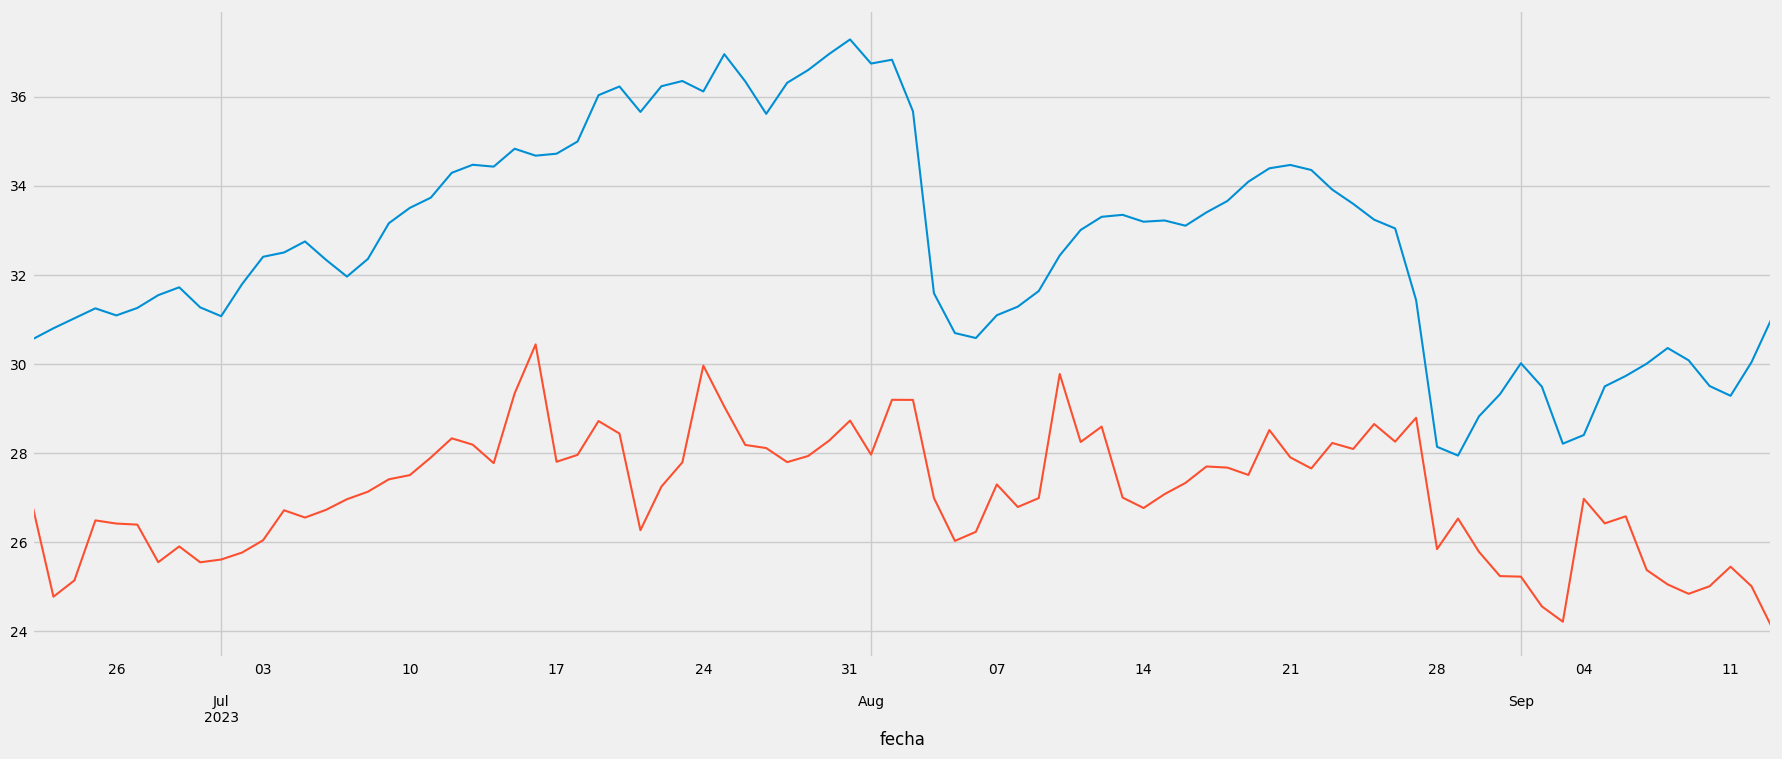

In [49]:
fig, ax = plt.subplots(figsize=(20, 8))
datos_reshape['temperatura'].plot(ax=ax, label='train')
datos_reshape['ambiente'].plot(ax=ax, label='train')

In [51]:
plt.style.use('default')

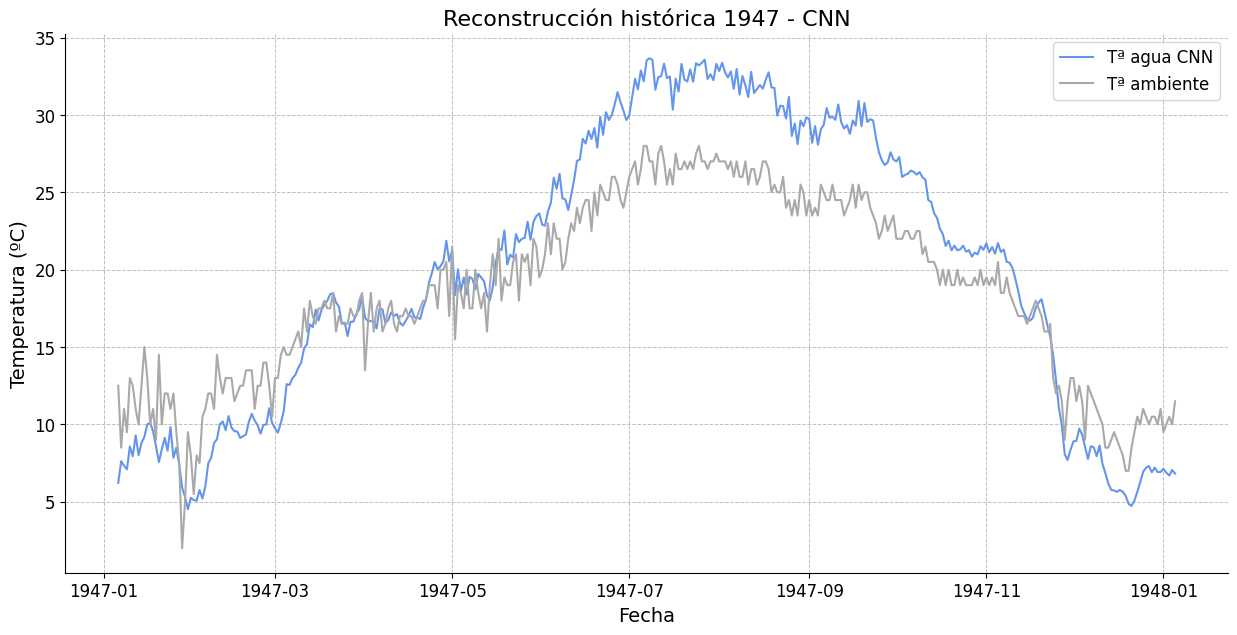

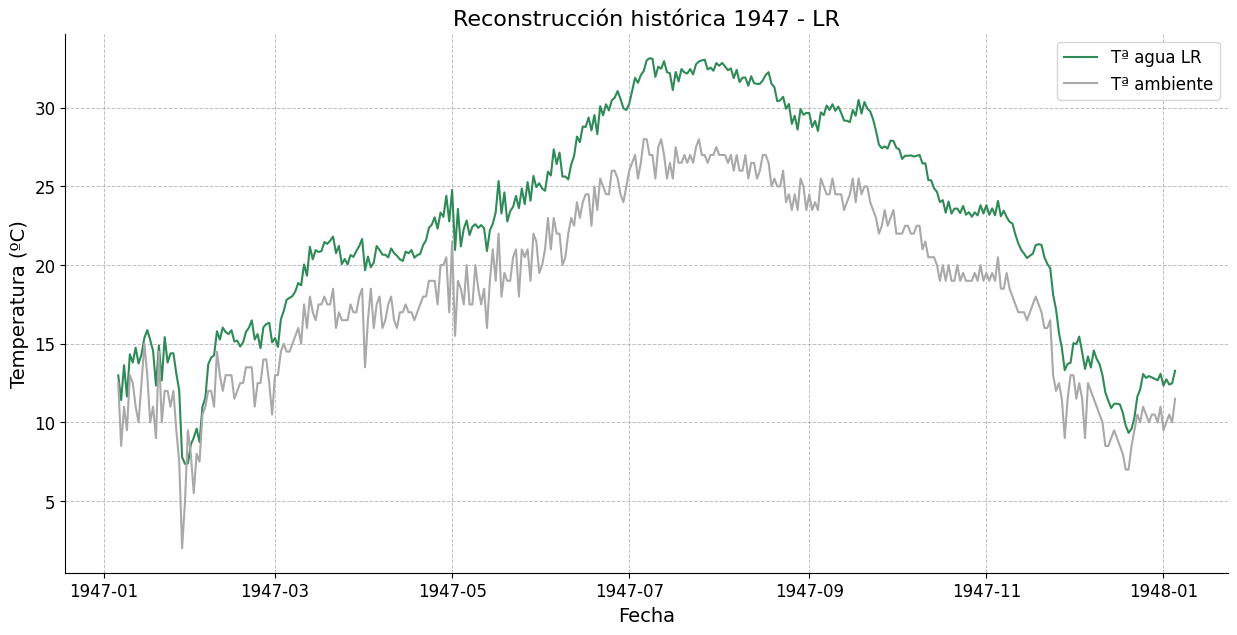

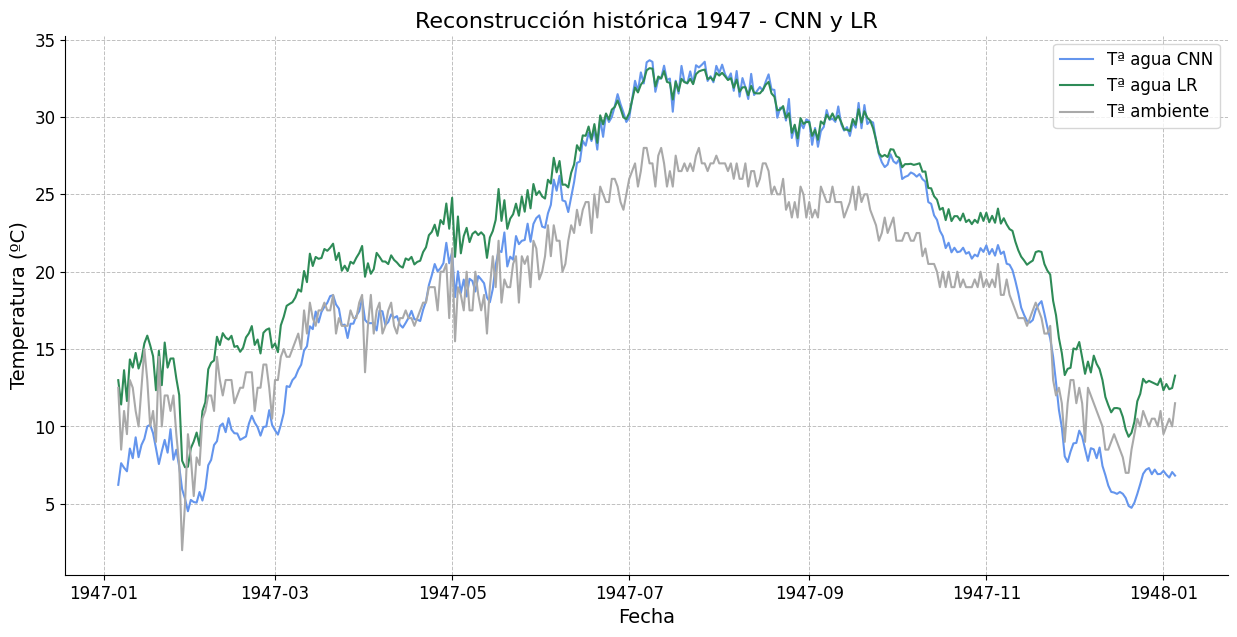

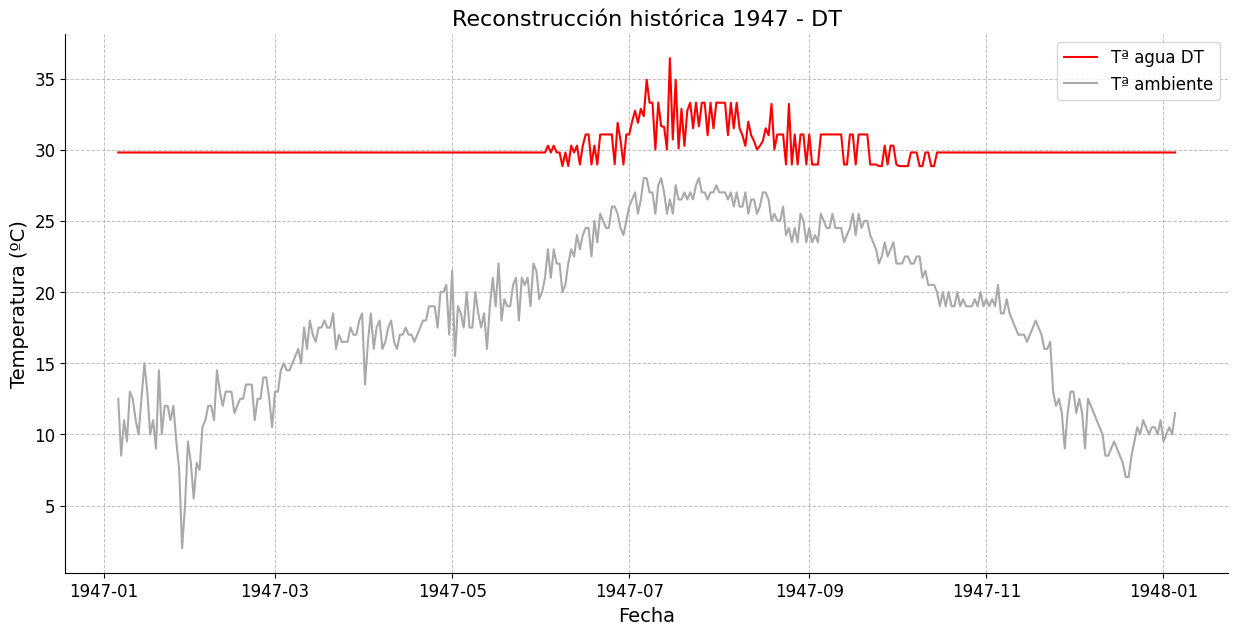

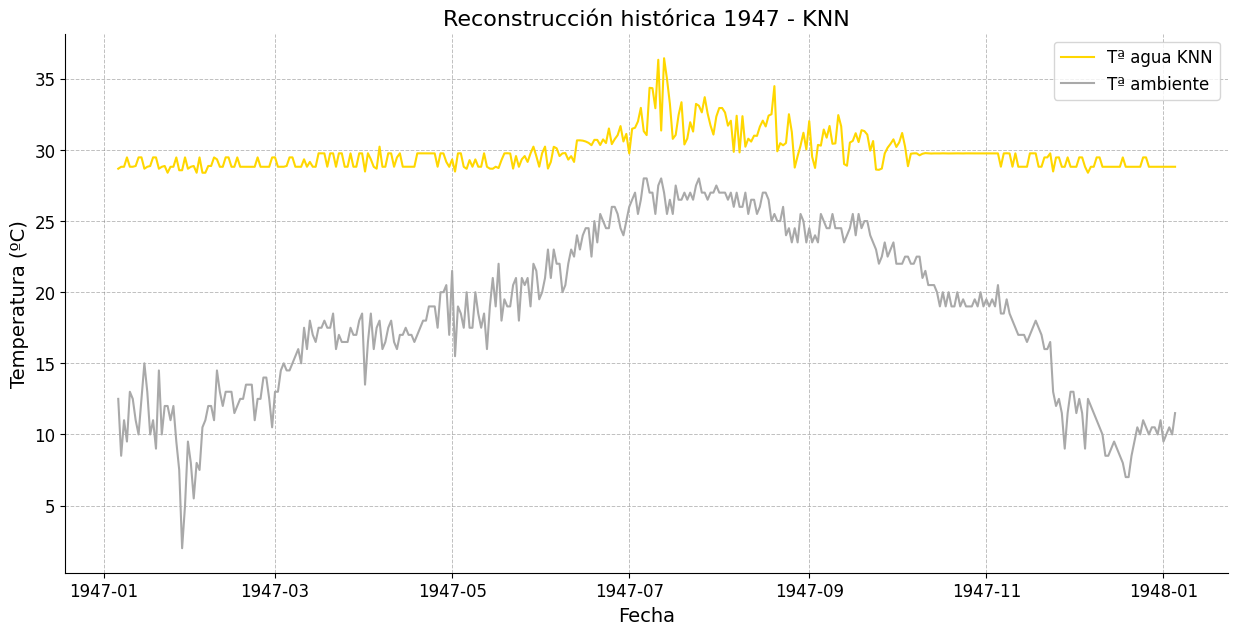

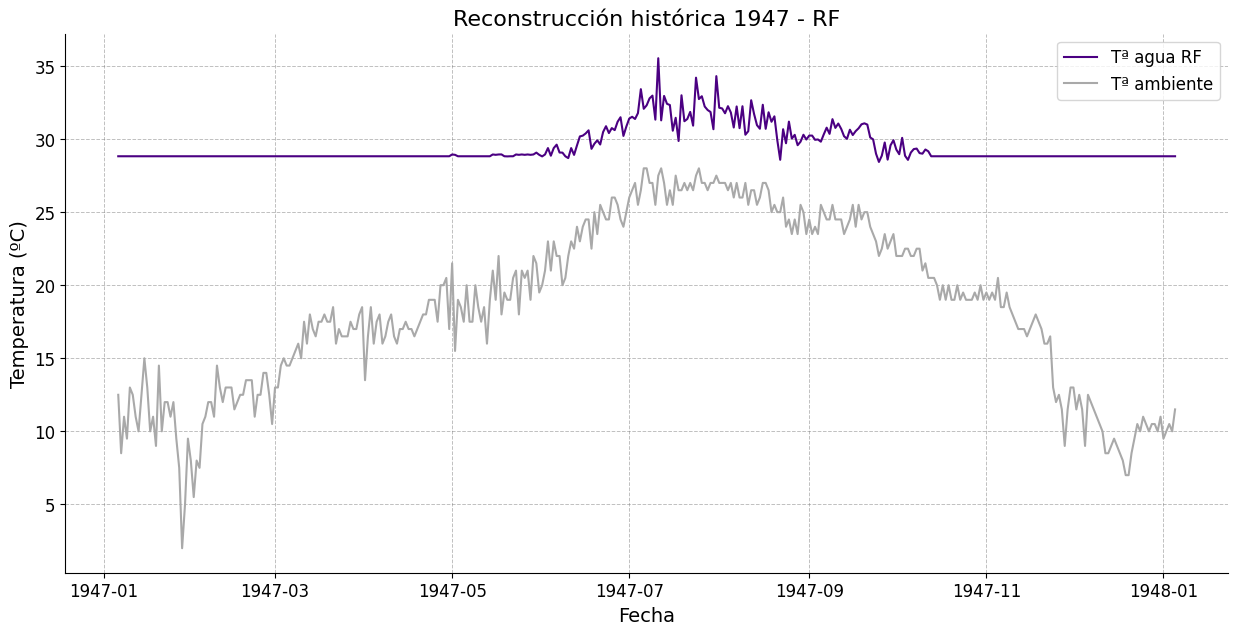

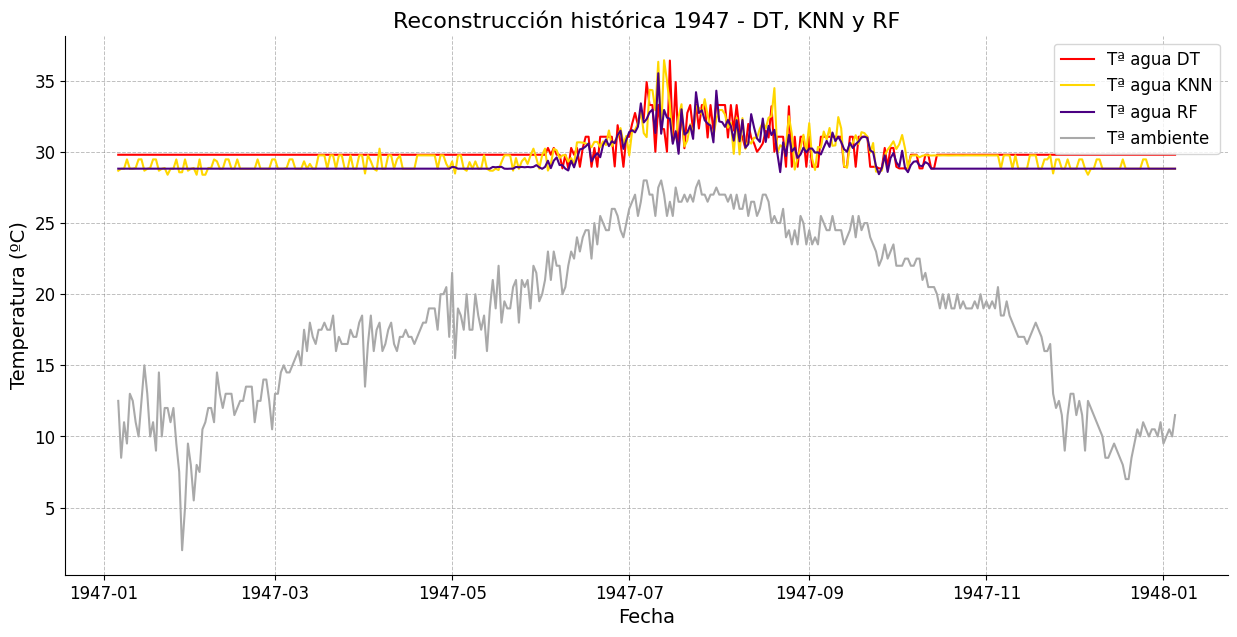

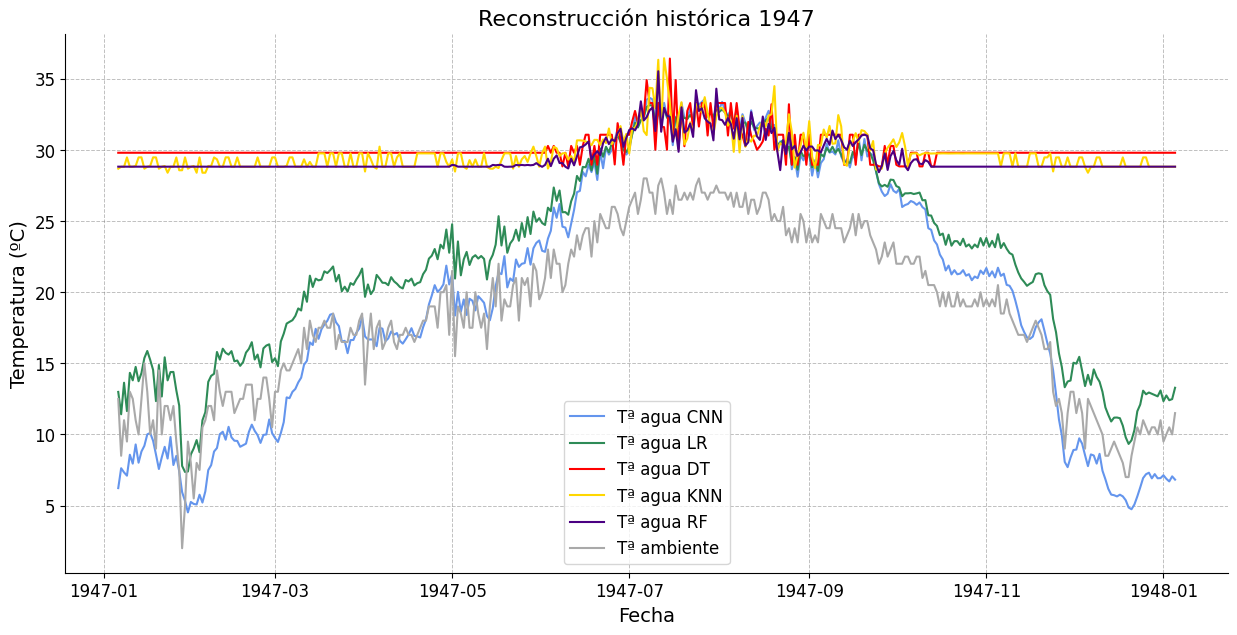

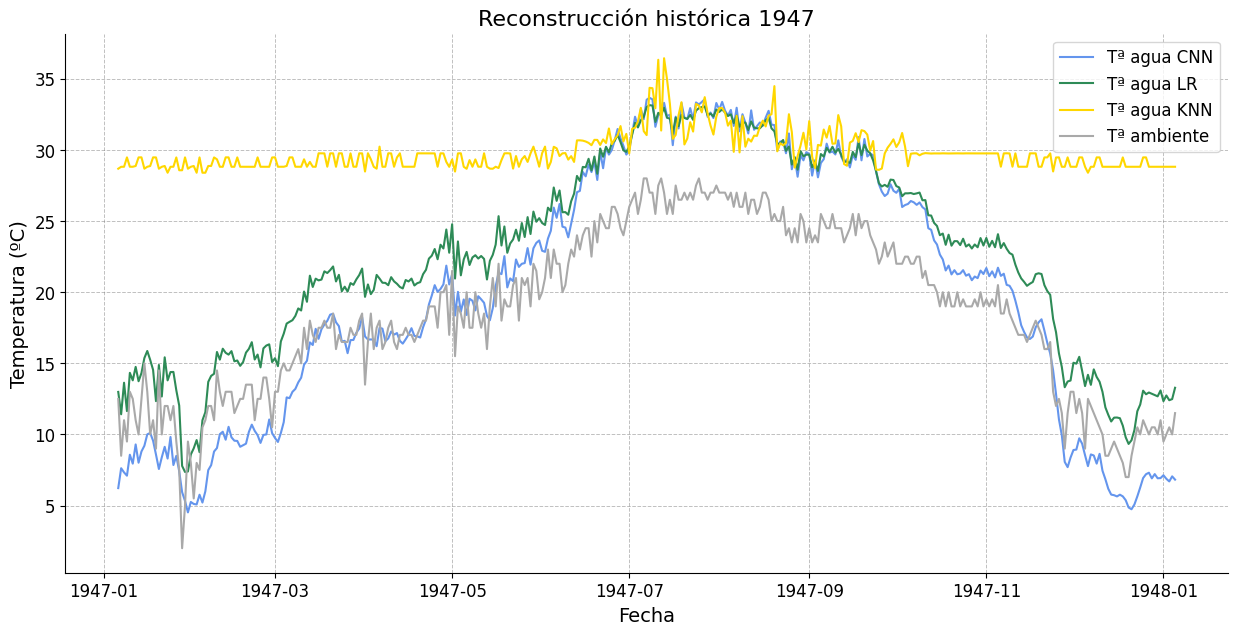

In [62]:
colores = ["cornflowerblue", "seagreen","indigo","red","chocolate","orchid","darkgray","gold"]

plt.figure(figsize=(15,7))


l1 = plt.plot(dfwork["temp_agua_CNN"].iloc[:365], color='cornflowerblue', label="Tª agua CNN")
plt.setp(l1, markersize=8)

q = plt.plot(dfwork["ambiente"].iloc[:365] , color='darkgray', label="Tª ambiente")

# Configuración de los ejes y títulos
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Temperatura (ºC)', fontsize=14)
plt.title(f'Reconstrucción histórica 1947 - CNN', fontsize=16)

# Quitar los bordes superior y derecho
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar el tamaño de la leyenda
plt.legend(fontsize=12)

# Ajustar el tamaño de las etiquetas de los ejes
ax.tick_params(axis='both', which='major', labelsize=12)

# Configurar la cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='grey', alpha = 0.5)

# Guardar el gráfico en una carpeta con buena resolución
plt.savefig(f"recons_1947_CNN.png", dpi=300, bbox_inches='tight')
plt.show()

#############################################################################

plt.figure(figsize=(15,7))

l3 = plt.plot(dfwork["temp_agua_LR"].iloc[:365], color='seagreen', label="Tª agua LR")
plt.setp(l3, markersize=8)


q = plt.plot(dfwork["ambiente"].iloc[:365] , color='darkgray', label="Tª ambiente")

# Configuración de los ejes y títulos
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Temperatura (ºC)', fontsize=14)
plt.title(f'Reconstrucción histórica 1947 - LR', fontsize=16)

# Quitar los bordes superior y derecho
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar el tamaño de la leyenda
plt.legend(fontsize=12)

# Ajustar el tamaño de las etiquetas de los ejes
ax.tick_params(axis='both', which='major', labelsize=12)

# Configurar la cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='grey', alpha = 0.5)

# Guardar el gráfico en una carpeta con buena resolución
plt.savefig(f"recons_1947_LR.png", dpi=300, bbox_inches='tight')
plt.show()

#############################################################################

plt.figure(figsize=(15,7))

plt.title('Y_predict')
l1 = plt.plot(dfwork["temp_agua_CNN"].iloc[:365], color='cornflowerblue', label="Tª agua CNN")
plt.setp(l1, markersize=8)

l3 = plt.plot(dfwork["temp_agua_LR"].iloc[:365], color='seagreen', label="Tª agua LR")
plt.setp(l3, markersize=8)

q = plt.plot(dfwork["ambiente"].iloc[:365] , color='darkgray', label="Tª ambiente")

# Configuración de los ejes y títulos
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Temperatura (ºC)', fontsize=14)
plt.title(f'Reconstrucción histórica 1947 - CNN y LR', fontsize=16)

# Quitar los bordes superior y derecho
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar el tamaño de la leyenda
plt.legend(fontsize=12)

# Ajustar el tamaño de las etiquetas de los ejes
ax.tick_params(axis='both', which='major', labelsize=12)

# Configurar la cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='grey', alpha = 0.5)

# Guardar el gráfico en una carpeta con buena resolución
plt.savefig(f"recons_1947_CNN_LR.png", dpi=300, bbox_inches='tight')
plt.show()

#############################################################################

plt.figure(figsize=(15,7))

l3 = plt.plot(dfwork["temp_agua_DT"].iloc[:365], color='red', label="Tª agua DT")
plt.setp(l3, markersize=8)

q = plt.plot(dfwork["ambiente"].iloc[:365] , color='darkgray', label="Tª ambiente")

# Configuración de los ejes y títulos
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Temperatura (ºC)', fontsize=14)
plt.title(f'Reconstrucción histórica 1947 - DT', fontsize=16)

# Quitar los bordes superior y derecho
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar el tamaño de la leyenda
plt.legend(fontsize=12)

# Ajustar el tamaño de las etiquetas de los ejes
ax.tick_params(axis='both', which='major', labelsize=12)

# Configurar la cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='grey', alpha = 0.5)

# Guardar el gráfico en una carpeta con buena resolución
plt.savefig(f"recons_1947_DT.png", dpi=300, bbox_inches='tight')
plt.show()

#############################################################################

plt.figure(figsize=(15,7))


l4 = plt.plot(dfwork["temp_agua_KN"].iloc[:365], color='gold', label="Tª agua KNN")
plt.setp(l4, markersize=8)


q = plt.plot(dfwork["ambiente"].iloc[:365] , color='darkgray', label="Tª ambiente")


# Configuración de los ejes y títulos
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Temperatura (ºC)', fontsize=14)
plt.title(f'Reconstrucción histórica 1947 - KNN', fontsize=16)

# Quitar los bordes superior y derecho
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar el tamaño de la leyenda
plt.legend(fontsize=12)

# Ajustar el tamaño de las etiquetas de los ejes
ax.tick_params(axis='both', which='major', labelsize=12)

# Configurar la cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='grey', alpha = 0.5)

# Guardar el gráfico en una carpeta con buena resolución
plt.savefig(f"recons_1947_KNN.png", dpi=300, bbox_inches='tight')
plt.show()

#############################################################################

plt.figure(figsize=(15,7))

l5 = plt.plot(dfwork["temp_agua_RF"].iloc[:365], color='indigo', label="Tª agua RF")
plt.setp(l5, markersize=8)

q = plt.plot(dfwork["ambiente"].iloc[:365] , color='darkgray', label="Tª ambiente")

# Configuración de los ejes y títulos
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Temperatura (ºC)', fontsize=14)
plt.title(f'Reconstrucción histórica 1947 - RF', fontsize=16)

# Quitar los bordes superior y derecho
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar el tamaño de la leyenda
plt.legend(fontsize=12)

# Ajustar el tamaño de las etiquetas de los ejes
ax.tick_params(axis='both', which='major', labelsize=12)

# Configurar la cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='grey', alpha = 0.5)

# Guardar el gráfico en una carpeta con buena resolución
plt.savefig(f"recons_1947_RF.png", dpi=300, bbox_inches='tight')
plt.show()

#############################################################################

plt.figure(figsize=(15,7))

l3 = plt.plot(dfwork["temp_agua_DT"].iloc[:365], color='red', label="Tª agua DT")
plt.setp(l3, markersize=8)

l4 = plt.plot(dfwork["temp_agua_KN"].iloc[:365], color='gold', label="Tª agua KNN")
plt.setp(l4, markersize=8)

l5 = plt.plot(dfwork["temp_agua_RF"].iloc[:365], color='indigo', label="Tª agua RF")
plt.setp(l5, markersize=8)

q = plt.plot(dfwork["ambiente"].iloc[:365] , color='darkgray', label="Tª ambiente")

# Configuración de los ejes y títulos
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Temperatura (ºC)', fontsize=14)
plt.title(f'Reconstrucción histórica 1947 - DT, KNN y RF', fontsize=16)

# Quitar los bordes superior y derecho
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar el tamaño de la leyenda
plt.legend(fontsize=12)

# Ajustar el tamaño de las etiquetas de los ejes
ax.tick_params(axis='both', which='major', labelsize=12)

# Configurar la cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='grey', alpha = 0.5)

# Guardar el gráfico en una carpeta con buena resolución
plt.savefig(f"recons_1947_DT_KNN_RF.png", dpi=300, bbox_inches='tight')
plt.show()

#############################################################################

plt.figure(figsize=(15,7))
l1 = plt.plot(dfwork["temp_agua_CNN"].iloc[:365], color='cornflowerblue', label="Tª agua CNN")
plt.setp(l1, markersize=8)

l3 = plt.plot(dfwork["temp_agua_LR"].iloc[:365], color='seagreen', label="Tª agua LR")
plt.setp(l3, markersize=8)

l3 = plt.plot(dfwork["temp_agua_DT"].iloc[:365], color='red', label="Tª agua DT")
plt.setp(l3, markersize=8)

l4 = plt.plot(dfwork["temp_agua_KN"].iloc[:365], color='gold', label="Tª agua KNN")
plt.setp(l4, markersize=8)

l5 = plt.plot(dfwork["temp_agua_RF"].iloc[:365], color='indigo', label="Tª agua RF")
plt.setp(l5, markersize=8)


q = plt.plot(dfwork["ambiente"].iloc[:365] , color='darkgray', label="Tª ambiente")

# Configuración de los ejes y títulos
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Temperatura (ºC)', fontsize=14)
plt.title(f'Reconstrucción histórica 1947', fontsize=16)

# Quitar los bordes superior y derecho
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar el tamaño de la leyenda
plt.legend(fontsize=12)

# Ajustar el tamaño de las etiquetas de los ejes
ax.tick_params(axis='both', which='major', labelsize=12)

# Configurar la cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='grey', alpha = 0.5)

# Guardar el gráfico en una carpeta con buena resolución
plt.savefig(f"recons_1947_1.png", dpi=300, bbox_inches='tight')
plt.show()

#############################################################################

plt.figure(figsize=(15,7))
l1 = plt.plot(dfwork["temp_agua_CNN"].iloc[:365], color='cornflowerblue', label="Tª agua CNN")
plt.setp(l1, markersize=8)

l3 = plt.plot(dfwork["temp_agua_LR"].iloc[:365], color='seagreen', label="Tª agua LR")
# plt.setp(l3, markersize=8)

# l3 = plt.plot(dfwork["temp_agua_DT"].iloc[:365], color='red', label="Tª agua DT")
# plt.setp(l3, markersize=8)

l4 = plt.plot(dfwork["temp_agua_KN"].iloc[:365], color='gold', label="Tª agua KNN")
plt.setp(l4, markersize=8)

# l5 = plt.plot(dfwork["temp_agua_RF"].iloc[:365], color='indigo', label="Tª agua RF")
# plt.setp(l5, markersize=8)


q = plt.plot(dfwork["ambiente"].iloc[:365] , color='darkgray', label="Tª ambiente")

# Configuración de los ejes y títulos
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Temperatura (ºC)', fontsize=14)
plt.title(f'Reconstrucción histórica 1947', fontsize=16)

# Quitar los bordes superior y derecho
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar el tamaño de la leyenda
plt.legend(fontsize=12)

# Ajustar el tamaño de las etiquetas de los ejes
ax.tick_params(axis='both', which='major', labelsize=12)

# Configurar la cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='grey', alpha = 0.5)

# Guardar el gráfico en una carpeta con buena resolución
plt.savefig(f"recons_1947_2.png", dpi=300, bbox_inches='tight')
plt.show()

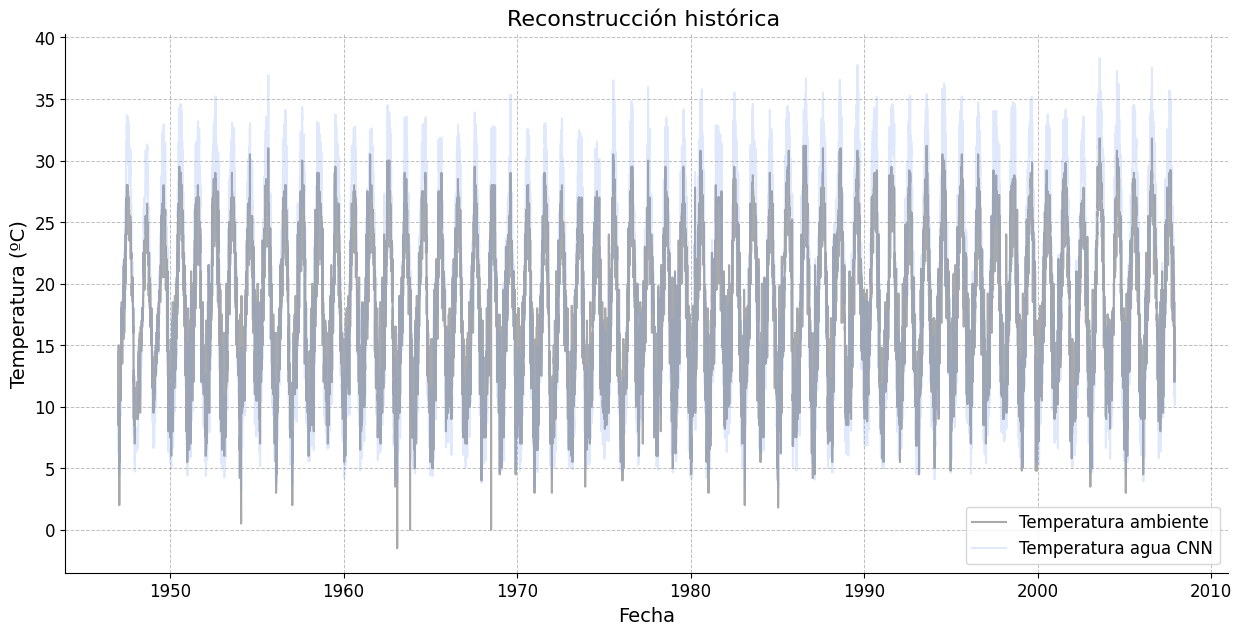

In [63]:
colores = ["cornflowerblue", "seagreen","indigo","red","chocolate","orchid","darkgray","gold"]

plt.figure(figsize=(15,7))

q = plt.plot(dfwork["ambiente"] , color='darkgray', label="Temperatura ambiente", alpha = 1)
l1 = plt.plot(dfwork["temp_agua_CNN"], color='cornflowerblue', label="Temperatura agua CNN", alpha = 0.2)
plt.setp(l1, markersize=8)


# l3 = plt.plot(dfwork["temp_agua_LR"], color='seagreen', label="Temperatura agua LR", alpha = 0.5)
# plt.setp(l3, markersize=8)



# Configuración de los ejes y títulos
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Temperatura (ºC)', fontsize=14)
plt.title(f'Reconstrucción histórica ', fontsize=16)

# Quitar los bordes superior y derecho
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar el tamaño de la leyenda
plt.legend(fontsize=12)

# Ajustar el tamaño de las etiquetas de los ejes
ax.tick_params(axis='both', which='major', labelsize=12)

# Configurar la cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='grey', alpha = 0.5)

# Guardar el gráfico en una carpeta con buena resolución
plt.savefig(f"recons_hist.png", dpi=300, bbox_inches='tight')
plt.show()

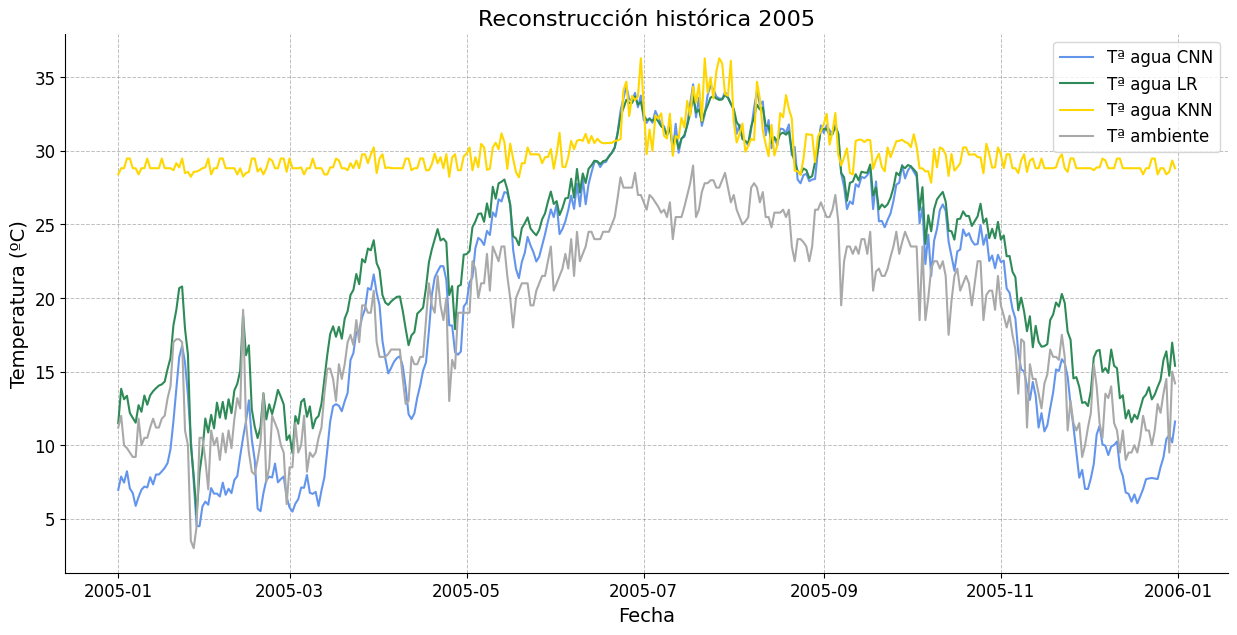

In [64]:
colores = ["cornflowerblue", "seagreen","indigo","red","chocolate","orchid","darkgray","gold"]

plt.figure(figsize=(15,7))


dfwork.iloc[21180:21545]

plt.title('Y_predict')
l1 = plt.plot(dfwork["temp_agua_CNN"].iloc[21180:21545], color='cornflowerblue', label="Tª agua CNN")
plt.setp(l1, markersize=8)

l3 = plt.plot(dfwork["temp_agua_LR"].iloc[21180:21545], color='seagreen', label="Tª agua LR")
plt.setp(l3, markersize=8)

# l3 = plt.plot(dfwork["temp_agua_DT"].iloc[21180:21545], color='red', label="Tª agua DT")
# plt.setp(l3, markersize=8)

l4 = plt.plot(dfwork["temp_agua_KN"].iloc[21180:21545], color='gold', label="Tª agua KNN")
plt.setp(l4, markersize=8)

# l5 = plt.plot(dfwork["temp_agua_RF"].iloc[21180:21545], color='indigo', label="Tª agua RF")
# plt.setp(l5, markersize=8)


q = plt.plot(dfwork["ambiente"].iloc[21180:21545] , color='darkgray', label="Tª ambiente")

# Configuración de los ejes y títulos
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Temperatura (ºC)', fontsize=14)
plt.title(f'Reconstrucción histórica 2005', fontsize=16)

# Quitar los bordes superior y derecho
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar el tamaño de la leyenda
plt.legend(fontsize=12)

# Ajustar el tamaño de las etiquetas de los ejes
ax.tick_params(axis='both', which='major', labelsize=12)

# Configurar la cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='grey', alpha = 0.5)

# Guardar el gráfico en una carpeta con buena resolución
plt.savefig(f"recons_2005.png", dpi=300, bbox_inches='tight')
plt.show()

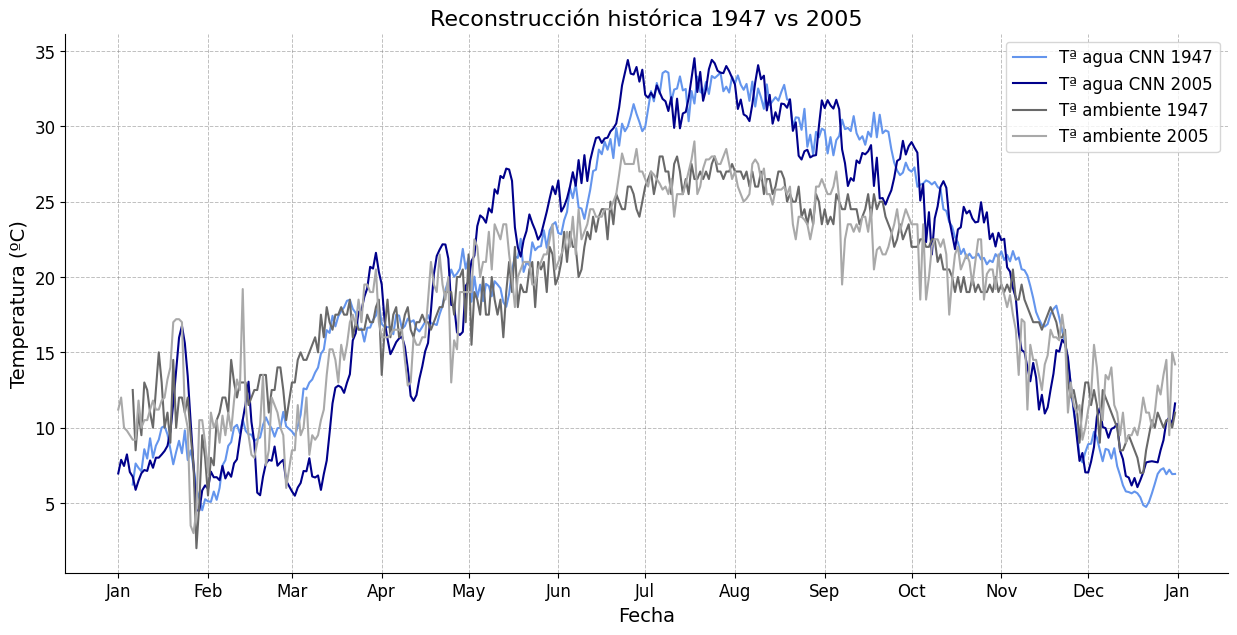

In [65]:
import matplotlib.dates as mdates
dfwork.index = pd.to_datetime(dfwork.index)
# Extraer el mes y el día de las fechas
dfwork['mes_dia'] = dfwork.index.strftime('%m-%d')

dfwork['mes_dia'] = pd.to_datetime(dfwork.index.strftime('2000-%m-%d'))

df_comparacion  = dfwork[['mes_dia', 'temp_agua_CNN', 'temp_agua_RNN', 'temp_agua_LR', 'temp_agua_DT', 'temp_agua_KN', 'temp_agua_RF', 'ambiente']]

df_comparacion .set_index('mes_dia', inplace=True)

plt.figure(figsize=(15,7))


# dfwork.iloc[21180:21545]

plt.title('Y_predict')
l1 = plt.plot(df_comparacion["temp_agua_CNN"].iloc[:360], color='cornflowerblue', label="Tª agua CNN 1947")
plt.setp(l1, markersize=8)

l1 = plt.plot(df_comparacion ["temp_agua_CNN"].iloc[21180:21545], color='darkblue', label="Tª agua CNN 2005")
plt.setp(l1, markersize=8)

q = plt.plot(df_comparacion ["ambiente"].iloc[:360] , color='dimgray', label="Tª ambiente 1947")
q = plt.plot(df_comparacion ["ambiente"].iloc[21180:21545] , color='darkgray', label="Tª ambiente 2005")

# Configuración de los ejes y títulos
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Temperatura (ºC)', fontsize=14)
plt.title(f'Reconstrucción histórica 1947 vs 2005', fontsize=16)

# Quitar los bordes superior y derecho
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar el tamaño de la leyenda
plt.legend(fontsize=12)

# Ajustar el tamaño de las etiquetas de los ejes
ax.tick_params(axis='both', which='major', labelsize=12)

# Configurar la cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='grey', alpha = 0.5)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Guardar el gráfico en una carpeta con buena resolución
plt.savefig(f"recons_1947_2005.png", dpi=300, bbox_inches='tight')
plt.show()